In [1]:
from rdkit import Chem
from rdkit.Chem import Descriptors

# 示例 SMILES 字符串
smiles = "CC(O)C=O"

# 将 SMILES 字符串转换为 RDKit 分子对象
mol = Chem.MolFromSmiles(smiles)

print("Atom Properties:")
print("Atom Index, Atom Type, Formal Charge, Hybridization Type, Degree, Explicit Valence, Atomic Mass, Aromaticity")
for atom in mol.GetAtoms():
    print(f"{atom.GetIdx()}, {atom.GetSymbol()}, {atom.GetFormalCharge()}, {atom.GetHybridization()}, "
          f"{atom.GetDegree()}, {atom.GetExplicitValence()}, {atom.GetMass()}, {atom.GetIsAromatic()}")

print("\nBond Properties:")
print("Bond Index, Bond Type, In Ring, Conjugated, Aromatic, Stereo")
bonds = mol.GetBonds()
for idx, bond in enumerate(bonds):
    print(f"{idx}, {bond.GetBondType()}, {bond.IsInRing()}, {bond.GetIsConjugated()}, "
          f"{bond.GetIsAromatic()}, {bond.GetStereo()}")



Atom Properties:
Atom Index, Atom Type, Formal Charge, Hybridization Type, Degree, Explicit Valence, Atomic Mass, Aromaticity
0, C, 0, SP3, 1, 1, 12.011, False
1, C, 0, SP3, 3, 3, 12.011, False
2, O, 0, SP3, 1, 1, 15.999, False
3, C, 0, SP2, 2, 3, 12.011, False
4, O, 0, SP2, 1, 2, 15.999, False

Bond Properties:
Bond Index, Bond Type, In Ring, Conjugated, Aromatic, Stereo
0, SINGLE, False, False, False, STEREONONE
1, SINGLE, False, False, False, STEREONONE
2, SINGLE, False, False, False, STEREONONE
3, DOUBLE, False, False, False, STEREONONE


In [18]:
import pandas as pd
from rdkit import Chem

# 读取CSV文件
df = pd.read_csv("Inhibitor1368_data/Inhibitor1368_molecular_properties.csv")

# 计算N、S、O、P原子数量
def count_atoms(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None, None, None, None
    atom_count = mol.GetNumAtoms()
    n_count = sum(1 for atom in mol.GetAtoms() if atom.GetSymbol() == 'N')
    s_count = sum(1 for atom in mol.GetAtoms() if atom.GetSymbol() == 'S')
    o_count = sum(1 for atom in mol.GetAtoms() if atom.GetSymbol() == 'O')
    p_count = sum(1 for atom in mol.GetAtoms() if atom.GetSymbol() == 'P')
    return n_count, s_count, o_count, p_count

# 添加新列
df[['N_count', 'S_count', 'O_count', 'P_count']] = df['SMILES'].apply(lambda x: pd.Series(count_atoms(x)))

# 保存回原来的CSV文件
df.to_csv("Inhibitor1368_data/Inhibitor1368_molecular_properties_new_N_O_S_P.csv", index=False)


In [2]:
"""
建立随机森林模型，以QED，	LogP，MolWt	，HBA，	HBD，	TPSA，	NumRotBonds，Concentration_mM作为特征输入，预测IE。
"""
import pandas as pd
from sklearn.model_selection import cross_validate, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
from math import sqrt

# 自定义RMSE评分函数
def rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

# 1. 加载数据
df = pd.read_csv('Inhibitor1368_data/Inhibitor1368_molecular_properties.csv')

# 2. 数据预处理
# 检查缺失值
if df.isnull().values.any():
    df = df.dropna()  # 删除有缺失值的行

# 3. 设置特征和目标变量
X = df[['QED', 'LogP', 'MolWt', 'HBA', 'HBD', 'TPSA', 'NumRotBonds', 'Concentration_mM']]
y = df['IE']

# 4. 建立模型
model = RandomForestRegressor(n_estimators=100, random_state=42)

# 5. 交叉验证
# 定义K折交叉验证方法
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 执行交叉验证
scoring = {'RMSE': make_scorer(rmse, greater_is_better=False),
           'MAE': 'neg_mean_absolute_error',
           'R2': 'r2'}

results = cross_validate(model, X, y, cv=kf, scoring=scoring, return_train_score=False)

# 输出结果
print("Cross-validated RMSE scores:", -results['test_RMSE'])
print("Average RMSE:", -results['test_RMSE'].mean())
print("Cross-validated MAE scores:", -results['test_MAE'])
print("Average MAE:", -results['test_MAE'].mean())
print("Cross-validated R2 scores:", results['test_R2'])
print("Average R2:", results['test_R2'].mean())


Cross-validated RMSE scores: [0.10060411 0.10787699 0.09871395 0.09147135 0.11848705]
Average RMSE: 0.10343069110585132
Cross-validated MAE scores: [0.07193558 0.07203391 0.06857953 0.06491608 0.07661978]
Average MAE: 0.07081697533980261
Cross-validated R2 scores: [0.63503114 0.67490035 0.65060772 0.68142348 0.5775679 ]
Average R2: 0.6439061181626353


In [1]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
from math import sqrt

# 自定义RMSE评分函数
def rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

# 1. 加载数据
df = pd.read_csv('Inhibitor1368_data/Inhibitor1368_molecular_properties.csv')

# 2. 数据预处理
# 检查缺失值
if df.isnull().values.any():
    df = df.dropna()  # 删除有缺失值的行

# 3. 设置特征和目标变量
X = df[['QED', 'LogP', 'MolWt', 'HBA', 'HBD', 'TPSA', 'NumRotBonds', 'Concentration_mM']]
y = df['IE']

# 4. 定义参数网格
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# 5. 建立模型
model = RandomForestRegressor(random_state=42)

# 6. 定义K折交叉验证方法
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# 7. 定义评分字典
scoring = {'RMSE': make_scorer(rmse, greater_is_better=False),
           'MAE': 'neg_mean_absolute_error',
           'R2': 'r2'}

# 8. 网格搜索
grid_search = GridSearchCV(model, param_grid, cv=kf, scoring=scoring, refit='RMSE', verbose=3, n_jobs=-1)
grid_search.fit(X, y)

# 9. 打印最优参数及性能指标值
print("Best parameters:", grid_search.best_params_)
print("Best RMSE:", -grid_search.best_score_)
print("Best MAE:", -grid_search.cv_results_['mean_test_MAE'][grid_search.best_index_])
print("Best R2:", grid_search.cv_results_['mean_test_R2'][grid_search.best_index_])

# 10. 将结果存储到DataFrame中
results_df = pd.DataFrame(grid_search.cv_results_)

# 11. 保存结果到CSV文件
results_df.to_csv('RF_IE_grid_search_results.csv', index=False)


Fitting 10 folds for each of 81 candidates, totalling 810 fits
Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best RMSE: 0.09825072747847699
Best MAE: 0.06720100288424186
Best R2: 0.6770479101771572


Concentration_mM
1.0000    348
0.1000    253
0.0100    168
0.5000    155
0.0500    102
0.0010     94
5.0000     62
0.2500     33
0.0050     21
2.0000     20
0.2000     19
0.4000     12
0.8000      8
2.5000      8
1.2000      6
0.3000      5
0.7500      4
0.6000      4
1.5000      4
3.0000      4
0.0075      3
0.0750      3
1.2500      3
0.1500      3
4.0000      3
0.0210      2
0.0170      2
0.0130      2
0.0090      2
1.4000      2
0.1200      1
0.1800      1
0.0900      1
0.2700      1
0.0300      1
0.2900      1
0.4800      1
0.0015      1
0.1400      1
Name: count, dtype: int64


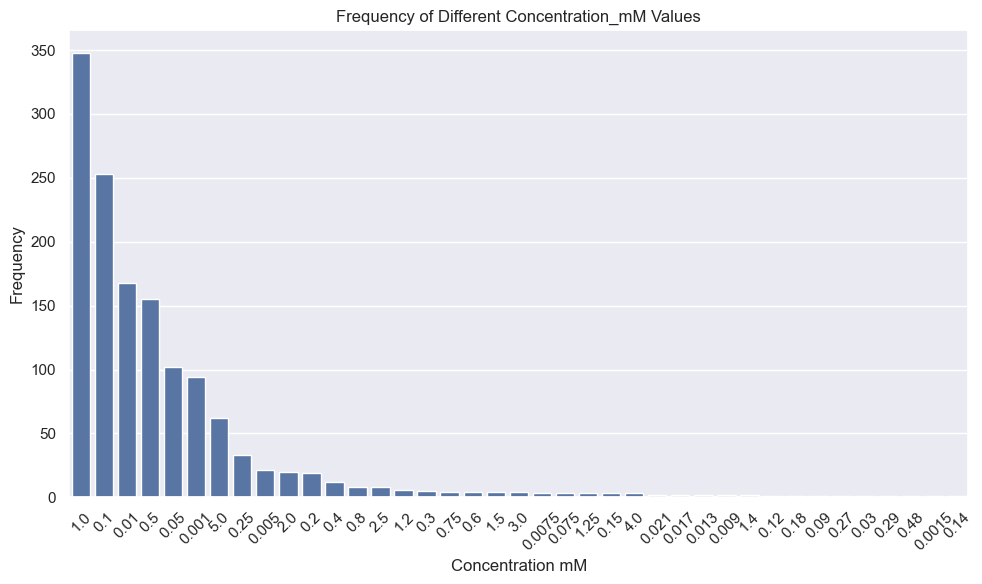

In [19]:
#Concentration_mM不同值出现的频次
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import pandas as pd

import matplotlib as mpl
mpl.rcParams['pdf.fonttype']=42
mpl.rcParams['ps.fonttype']=42
# 设置Seaborn风格
sns.set()

# 读取CSV文件
file_path = 'Inhibitor1368_data/Inhibitor1368_molecular_properties.csv'  # 更改为你的CSV文件路径
df = pd.read_csv(file_path)

# 查看Concentration_mM列的数据分布
print(df['Concentration_mM'].value_counts())

# 绘制Concentration_mM的频次直方图
plt.figure(figsize=(10, 6))  # 可以调整图片大小
sns.countplot(x='Concentration_mM', data=df, order=df['Concentration_mM'].value_counts().index)
plt.title('Frequency of Different Concentration_mM Values')
plt.xlabel('Concentration mM')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # 旋转x轴标签，以便更容易阅读
plt.tight_layout()  # 调整布局以适应标签
# 保存为PDF文件
plt.savefig('figures/Frequency_Concentration_mM_Values.pdf', format='pdf', bbox_inches='tight')
plt.show()


In [4]:
#读取新生成分子SMILEs式，并生成相关分子属性
from rdkit import Chem
from rdkit.Chem import QED, Descriptors, Lipinski, rdMolDescriptors
import pandas as pd

def compute_properties(smiles):
    if pd.isna(smiles):  # 检查smiles是否为NaN
        return None, None  # 如果是NaN，返回None
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        qed = QED.qed(mol)
        logp = Descriptors.MolLogP(mol)
        molwt = Descriptors.MolWt(mol)
        hba = Lipinski.NumHAcceptors(mol)
        hbd = Lipinski.NumHDonors(mol)
        tpsa = rdMolDescriptors.CalcTPSA(mol)
        num_rot_bonds = Lipinski.NumRotatableBonds(mol)
        # 将SMILES字符串作为列表的第一个元素返回
        return [smiles, qed, logp, molwt, hba, hbd, tpsa, num_rot_bonds]
    else:
        # 如果SMILES无效，返回None，同时保留SMILES字符串以便于识别
        return [smiles] + [None] * 7

# 假设txt文件实际上是一个CSV文件
smiles_path = 'Inhibitor1368_data/Inhibitor1368_data_0/transvae_Inhibitor1368_data_0_data_tanimoto_similarity_screen_same.csv'
# 读取CSV文件并指定它使用逗号分隔
#df = pd.read_csv(smiles_path, delimiter='\t')
df = pd.read_csv(smiles_path)
# 确保读取`reconstruct_smiles`列
properties_list = [compute_properties(smiles) for smiles in df['reconstruct_smiles']]

# 在列名列表中首先添加SMILES
properties_df = pd.DataFrame(properties_list, columns=['SMILES', 'QED', 'LogP', 'MolWt', 'HBA', 'HBD', 'TPSA', 'NumRotBonds'])

print(properties_df)

# 可以将结果保存到CSV文件
properties_df.to_csv('Inhibitor1368_data/Inhibitor1368_data_0/molecular_properties_transvae_Inhibitor1368_data_0_data_tanimoto_similarity_screen_same.csv', index=False)


                                               SMILES       QED     LogP  \
0   C[NH+]1CCN(CCO)C1.O=S(=O)([N-]S(=O)(=O)C(F)(F)...  0.564275 -1.17420   
1        C(COc1nc(OCCOCC2CO2)nc(OCCCCC2CO2)n1)OCC1CO1  0.238978  0.40790   
2   CC1(C)S[C@@H]2[C@H](NC(=O)C(N)c3ccc(O)cc3)C(=O...  0.553032  0.02370   
3                   O=Cc1cc2cc([N+](=O)[O-])ccc2nc1Cl  0.347683  2.60890   
4                  CCN(CC)CCN1C(=O)C(=O)c2cc(Br)ccc21  0.780336  2.32020   
5                            CCc1ccc(/C=N\NC(N)=S)cc1  0.447507  1.41610   
6                     Cc1ccc(-c2nc3ccccc3c(=O)n2C)cc1  0.665276  2.90892   
7                           CCCN(CCC)Cc1ccc2cccnc2c1O  0.860282  3.56240   
8   COc1cc(O)ccc1-c1nc(-c2ccccc2)c(-c2ccccc2)n1-c1...  0.350296  6.58750   
9   C(=N/c1ccc(Cc2ccc(/N=C/c3ccc4ccccc4n3)cc2)cc1)...  0.230060  7.82660   
10            Cc1ccc(/C=C/C(=O)c2ccc(OCC(=O)O)cc2)cc1  0.655570  3.35452   
11  Cc1ccc(/C=N\N=c2\[nH]c(C(C)(O)O)c(-c3ccc(Cl)cc...  0.361341  3.79712   
12          

In [7]:
"""读取csv文件，有SMILES，QED，LogP，MolWt，HBA，HBD，TPSA，NumRotBonds几个字段，
要求增加一列Concentration_mM，其中Concentration_mM值可选1,0.1,0.01,0.001，0.005，0.05，5，2，0.5,0.4,0.3，也就是说每行复制为11行，
然后将Concentration_mM值填充到Concentration_mM值列，最后保存到新的csv文件
"""
import pandas as pd

# 读取CSV文件
df = pd.read_csv('Inhibitor1368_data/Inhibitor1368_data_9/molecular_properties_transvae_Inhibitor1368_data_9_data_tanimoto_similarity_screen_same.csv')

# 定义Concentration_mM的可能值
concentration_values = [1, 0.1, 0.01, 0.5, 0.05, 0.001,5, 0.25, 0.005, 2, 0.2,0.4, 0.8,2.5]

# 重复每行，并为每个重复行分配不同的Concentration_mM值
# 创建一个空的DataFrame来存储最终结果
expanded_df = pd.DataFrame()

for index, row in df.iterrows():
    # 为当前行创建一个临时DataFrame，包含所有Concentration_mM值的重复行
    temp_df = pd.DataFrame([row] * len(concentration_values), columns=df.columns)
    temp_df['Concentration_mM'] = concentration_values
    
    # 将临时DataFrame添加到最终结果DataFrame
    expanded_df = pd.concat([expanded_df, temp_df], ignore_index=True)

# 将结果保存到新的CSV文件
expanded_df.to_csv('Inhibitor1368_data/Inhibitor1368_data_9/molecular_properties_transvae_Inhibitor1368_data_9_data_tanimoto_similarity_screen_same.csv', index=False)


In [13]:
"""
使用最优模型对新的CSV文件中的数据进行预测，并将预测结果保存回该CSV文件。这一过程包括读取新数据、预测IE值、添加预测结果到原始DataFrame，然后保存DataFrame。
"""
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

# 假定你已经找到了最优的模型参数
best_params = grid_search.best_params_

# 使用最优参数创建随机森林模型
best_model = RandomForestRegressor(**best_params, random_state=42)

# 使用所有数据重新训练模型（也可以只使用交叉验证中的最佳模型）
best_model.fit(X, y)

# 读取新的CSV文件，这里假设其结构与之前相同，仅没有IE列
new_data = pd.read_csv('Inhibitor1368_data/Inhibitor1368_data_0/molecular_properties_transvae_Inhibitor1368_data_0_data_tanimoto_similarity_screen_same.csv')

# 准备特征数据进行预测
X_new = new_data[['QED', 'LogP', 'MolWt', 'HBA', 'HBD', 'TPSA', 'NumRotBonds', 'Concentration_mM']]

# 进行预测
predicted_IE = best_model.predict(X_new)

# 将预测结果添加到新数据中的IE列
new_data['IE'] = predicted_IE

# 保存更新后的数据到CSV文件
new_data.to_csv('Inhibitor1368_data/Inhibitor1368_data_0/molecular_properties_transvae_Inhibitor1368_data_0__reconstruct.csv', index=False)


In [14]:
import pandas as pd

# 读取Inhibitor1368_molecular_properties.csv文件
df_molecular_properties = pd.read_csv('Inhibitor1368_data/Inhibitor1368_molecular_properties.csv')
print(df_molecular_properties.columns)

# 读取rnn_Inhibitor1368_mose_data_tanimoto_similarity.txt文件
df_tanimoto_similarity = pd.read_csv('Inhibitor1368_data/Inhibitor1368_data_0/transvae_Inhibitor1368_data_0_data_tanimoto_similarity_screen_same.csv')
print(df_tanimoto_similarity.columns)

# 读取molecular_properties_Inhibitor1368_mose_reconstruct_rnn.csv文件
df_mose_reconstruct_rnn = pd.read_csv('Inhibitor1368_data/Inhibitor1368_data_0/molecular_properties_transvae_Inhibitor1368_data_0__reconstruct.csv')
# 检查列名
print(df_mose_reconstruct_rnn.columns)

# 将reconstruct_smiles和raw_smiles列值用作索引
df_tanimoto_similarity.set_index(['reconstruct_smiles', 'raw_smiles'], inplace=True)
df_molecular_properties.set_index('SMILES', inplace=True)
df_mose_reconstruct_rnn.set_index('SMILES', inplace=True)

# 创建空的DataFrame来存储结果
result_df = pd.DataFrame(columns=['reconstruct_smiles', 'raw_smiles', 'tanimoto_similarity', 'Concentration_mM', 'IE_abs'])

# 遍历每一行，提取相关字段，并计算IE值的绝对差值
for index, row in df_tanimoto_similarity.iterrows():
    reconstruct_smiles = index[0]
    raw_smiles = index[1]
    tanimoto_similarity = row['tanimoto_similarity']

    try:
        # 检查是否存在匹配的数据
        if (reconstruct_smiles in df_mose_reconstruct_rnn.index) and (raw_smiles in df_molecular_properties.index):
            for i in range(0, 13):
                reconstruct_concentration_mM = df_mose_reconstruct_rnn.loc[reconstruct_smiles, 'Concentration_mM'].iloc[i]
                for j in range(0, 13):
                    try:
                        raw_concentration_mM = df_molecular_properties.loc[raw_smiles, 'Concentration_mM'].iloc[j]
        
                        # 打印一些关键信息，帮助诊断问题
                        #print(f"reconstruct_smiles: {reconstruct_smiles}, raw_smiles: {raw_smiles}")
                       # print(f"reconstruct_concentration_mM: {reconstruct_concentration_mM}, raw_concentration_mM: {raw_concentration_mM}")
        
                        # 如果两个Concentration_mM值匹配，则提取相应的IE值并计算绝对差值
                        if reconstruct_concentration_mM == raw_concentration_mM:
                            reconstruct_IE = df_mose_reconstruct_rnn.loc[reconstruct_smiles, 'IE'].iloc[i]
                            raw_IE = df_molecular_properties.loc[raw_smiles, 'IE'].iloc[j]
                            IE_abs = abs(reconstruct_IE - raw_IE)
        
                            # 将结果添加到DataFrame中
                            df_to_append = pd.DataFrame({'reconstruct_smiles': [reconstruct_smiles],
                                                         'raw_smiles': [raw_smiles],
                                                         'tanimoto_similarity': [tanimoto_similarity],
                                                         'Concentration_mM': [reconstruct_concentration_mM],
                                                         'IE_abs': [IE_abs]})
                            result_df = pd.concat([result_df, df_to_append], ignore_index=True)
                            #print(result_df)
                        else:
                            print("Concentration_mM values do not match!")
                    except IndexError:
                        print("Index out of range for raw concentration.")
        else:
            print("Matching data not found!")

    except Exception as e:
        print(f"Error occurred: {e}. Moving to the next iteration.")

# 打印结果
print(result_df)

# 将结果保存到新的CSV文件中
result_df.to_csv('Inhibitor1368_data/Inhibitor1368_data_0/transvae_IE_abs_result.csv', index=False)


Index(['SMILES', 'QED', 'LogP', 'MolWt', 'HBA', 'HBD', 'TPSA', 'NumRotBonds',
       'IE', 'Concentration_mM'],
      dtype='object')
Index(['id', 'reconstruct_smiles', 'raw_smiles', 'tanimoto_similarity',
       'reconstruct_molwt', 'reconstruct_logp', 'raw_molwt', 'raw_logp',
       'delta_molwt', 'delta_logp'],
      dtype='object')
Index(['SMILES', 'QED', 'LogP', 'MolWt', 'HBA', 'HBD', 'TPSA', 'NumRotBonds',
       'Concentration_mM', 'IE'],
      dtype='object')
Concentration_mM values do not match!
Index out of range for raw concentration.
Index out of range for raw concentration.
Index out of range for raw concentration.
Index out of range for raw concentration.
Index out of range for raw concentration.
Index out of range for raw concentration.
Index out of range for raw concentration.
Index out of range for raw concentration.
Index out of range for raw concentration.
Index out of range for raw concentration.
Index out of range for raw concentration.
Concentration_mM values do n

C:\Users\DELL\AppData\Local\Temp\ipykernel_23176\2028503397.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, df_to_append], ignore_index=True)


Index out of range for raw concentration.
Index out of range for raw concentration.
Index out of range for raw concentration.
Index out of range for raw concentration.
Concentration_mM values do not match!
Concentration_mM values do not match!
Concentration_mM values do not match!
Concentration_mM values do not match!
Index out of range for raw concentration.
Index out of range for raw concentration.
Index out of range for raw concentration.
Index out of range for raw concentration.
Index out of range for raw concentration.
Index out of range for raw concentration.
Index out of range for raw concentration.
Index out of range for raw concentration.
Index out of range for raw concentration.
Concentration_mM values do not match!
Concentration_mM values do not match!
Concentration_mM values do not match!
Concentration_mM values do not match!
Index out of range for raw concentration.
Index out of range for raw concentration.
Index out of range for raw concentration.
Index out of range for r

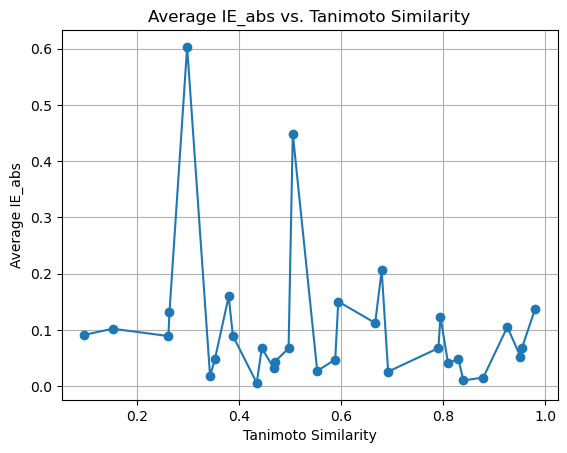

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import pandas as pd

import matplotlib as mpl
mpl.rcParams['pdf.fonttype']=42
mpl.rcParams['ps.fonttype']=42
# 读取 CSV 文件
df = pd.read_csv('Inhibitor1368_data/Inhibitor1368_data_0/transvae_IE_abs_result.csv')

# 按 tanimoto_similarity 分组并计算平均值
grouped_df = df.groupby('tanimoto_similarity')['IE_abs'].mean().reset_index()

# 绘制曲线
plt.plot(grouped_df['tanimoto_similarity'], grouped_df['IE_abs'], marker='o', linestyle='-')
plt.xlabel('Tanimoto Similarity')
plt.ylabel('Average IE_abs')
plt.title('Average IE_abs vs. Tanimoto Similarity')
plt.grid(True)
# 保存为PDF文件
plt.savefig('figures/Inhibitor1368_data_0_transvae_IE_abs_result.pdf', format='pdf', bbox_inches='tight')
plt.show()
